In [1]:
import pandas as pd

# Load data
campus_info = pd.read_csv('../../Data/SMTO_2015/Campus_Info.csv')
df = pd.read_csv('../../Data/SMTO_2015/SMTO_2015_Households.csv')[['HmTTS2006', 'hhlivingsituation', 'hhcarnumber','hhnumyoungerthan18','hhnumolderorequalto18','hhincomelevel']]
df = df.join(pd.read_csv('../../Data/SMTO_2015/SMTO_2015_Respondents.csv')[['pscampusattend', 'personstatusgrad', 'personstatustime', 'pscmpgender','psdrivinglicenseownerflag','psworknumhoursperweek']])
df.head()

,HmTTS2006,hhlivingsituation,hhcarnumber,hhnumyoungerthan18,hhnumolderorequalto18,hhincomelevel,pscampusattend,personstatusgrad,personstatustime,pscmpgender,psdrivinglicenseownerflag,psworknumhoursperweek
0,261.0,Live with family/parents,1,3,4,Unknown,Scarborough (UTSC),UG,FT,Female,0,NaN
1,71.0,Live with partner,0,0,2,"$ 90,000 - 119,999",Downtown Toronto (St. George),Grad,FT,Female,1,NaN
2,3714.0,Live with family/parents,1,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Female,1,NaN
3,74.0,Live with roommates,0,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Male,1,NaN
4,71.0,Live with partner,0,0,2,"$ 30,000 - 59,999",Downtown Toronto (St. George),Grad,FT,Male,1,NaN


In [2]:
df = df.rename(columns={'HmTTS2006': 'HomeZone', 'pscampusattend': 'Campus', 'hhlivingsituation': 'Family', 
                       'personstatusgrad': 'Level', 'personstatustime': 'Status', 'psuniversityinvolvednumyears': 'Years', 'hhcarnumber': 'Cars',
                       'hhincomelevel': 'Income', 'pscmpgender': 'Gender', 'psdrivinglicenseownerflag': 'Licence', 'psworknumhoursperweek': 'Work',
                       'hhnumyoungerthan18': 'Children', 'hhnumolderorequalto18':'Adults'})
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work'],
      dtype='object')

In [3]:
# Clean and reformat
df = df[df['HomeZone'].notnull()]
df = df[df['Campus'].notnull()]
df['HomeZone'] = pd.to_numeric(df['HomeZone'], downcast='signed')
df['Family'] = (df['Family'] == 'Live with family/parents')*1
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work'],
      dtype='object')

In [4]:
# Dataframe with walk distances
df_path = pd.read_csv('../../../LoS/Walk_Distances.csv')
origins = list(set(list(df_path['Origin'])))
dists = list(df_path['Data'])

# Function for distance lookup
def find_distance(origin, destination):
    try:
        i = origins.index(origin)
    except ValueError:
        return -1
    j = origins.index(destination)
    return dists[i*2392 + j] / 1000

# List of campus' TTS zones from Joven's MOE data
campus_zones = list(campus_info['Zone'])
school_codes = list(campus_info['Code'])

# Load distances into dataframe
for i in range(len(campus_zones)):
    df["Dist." + school_codes[i]] = df['HomeZone'].apply(lambda x: find_distance(x, campus_zones[i]))
df = df[df['Dist.SG'] != -1]
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work', 'Dist.SG', 'Dist.SC',
       'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC'],
      dtype='object')

In [5]:
y = df['Campus']
#x = df.drop(columns = ['HomeZone', 'Campus', 'Work'])
x = df[['Dist.SG', 'Dist.SC', 'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC']]
x = pd.get_dummies(x)
x.head()

,Dist.SG,Dist.SC,Dist.MI,Dist.YK,Dist.YG,Dist.RY,Dist.OC
0,10.256060,14.88098,29.20657,22.59214,9.218413,9.580635,11.241730
1,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838
2,23.319230,45.63271,4.51742,28.58045,32.555200,24.964000,23.686150
3,0.699414,24.11954,19.43932,16.81186,12.830410,2.314008,1.541276
4,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838


In [6]:
print(y.isnull().sum(), x.isnull().sum().sum())

0 0


In [145]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [146]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [147]:
print("Accuracy:", rf.score(X_test, y_test))

Accuracy: 0.4583333333333333


In [148]:
pd.Series(rf.feature_importances_, index = x.columns).sort_values(ascending=False)

Dist.SG    0.176057
Dist.SC    0.151474
Dist.OC    0.143416
Dist.YK    0.141086
Dist.RY    0.138290
Dist.MI    0.129784
Dist.YG    0.119893
dtype: float64

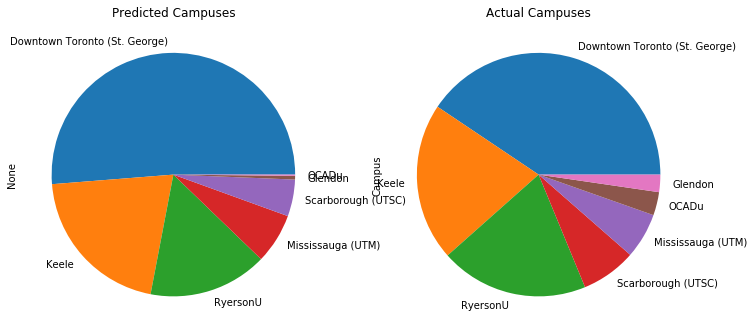

In [158]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 12))
plt.tight_layout()
plt.subplot(1, 2, 1)
pd.Series(y_pred).value_counts().plot.pie()
plt.title("Predicted Campuses")
plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().plot.pie()
plt.title("Actual Campuses")
plt.show()

In [150]:
probs = rf.predict_proba(X_test)
schools = list(rf.classes_)
results = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(probs)), axis=1)
results.apply(lambda x: x[schools.index(x.Campus)], axis=1).mean()

0.3845690585195698

In [151]:
import pickle
pickle.dump(rf, open('Location_Choice_Model', 'wb'))

# To open:
# model = pickle.load(open(filename, 'rb'))

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sn.heatmap(pd.crosstab(full_zones_df['HZ'], full_zones_df['Dists']), annot=True)
plt.show()